## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline

# Camera Calibration

## 1. Compute the camera calibration using chessboard images

In [3]:
def compute_camera_calibration(file_pattern='camera_cal/calibration*.jpg'):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    paths = glob.glob(file_pattern)
    
    for path in paths:
        # Read chessboard images
        img = cv2.imread(path)
        
        # Change color to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    # Compute the camera calibration
    _, camera_matrix, dist_coeffs, _, _ = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return camera_matrix, dist_coeffs

In [ ]:
def apply_undistortion(img, camera_matrix, dist_coeffs):
    return cv2.undistort(img, camera_matrix, dist_coeffs, None, camera_matrix)

In [ ]:
_camera_matrix, _dist_coeffs = compute_camera_calibration()
_file_pattern='camera_cal/calibration*.jpg'

_path = glob.glob(_file_pattern)[11]
_input_img = cv2.imread(_path)
_output_img = apply_undistortion(_input_img, _camera_matrix, _dist_coeffs)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title('input')
ax1.imshow(cv2.cvtColor(_input_img,cv2.COLOR_BGR2RGB))
ax2.set_title('output')
ax2.imshow(cv2.cvtColor(_output_img,cv2.COLOR_BGR2RGB))
plt.savefig(fname="output_images/camer_td.png")

# Pipeline

## 1. Correct distortion of an image

### 1.1. Provide an example of a distortion-corrected image.

In [26]:
# This is a test output of undistort_image(...)

_input_imgs_2 = []
_output_imgs_2 = []

_camera_matrix, _dist_coeffs = compute_camera_calibration()

for path in glob.glob('test_images/straight_lines*.jpg'):
    _input_img_2 = cv2.imread(path)
    _output_img_2 = apply_undistortion(_input_img_2, _camera_matrix, _dist_coeffs)
    
    _input_imgs_2.append(_input_img_2)
    _output_imgs_2.append(_output_img_2)

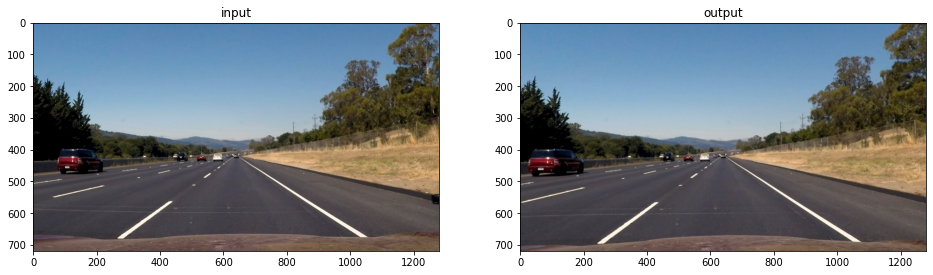

In [27]:
# Compare input and output images

_id = 0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title('input')
ax1.imshow(cv2.cvtColor(_input_imgs_2[_id],cv2.COLOR_BGR2RGB))
ax2.set_title('output')
ax2.imshow(cv2.cvtColor(_output_imgs_2[_id],cv2.COLOR_BGR2RGB))
plt.savefig(fname="output_images/undistort_output_{}.png".format(_id))

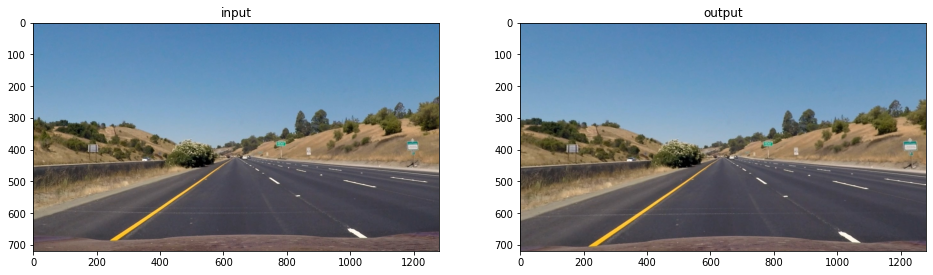

In [28]:
# Compare input and output images

_id = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title('input')
ax1.imshow(cv2.cvtColor(_input_imgs_2[_id],cv2.COLOR_BGR2RGB))
ax2.set_title('output')
ax2.imshow(cv2.cvtColor(_output_imgs_2[_id],cv2.COLOR_BGR2RGB))
plt.savefig(fname="output_images/undistort_output_{}.png".format(_id))

## 2. Create a thresholded binary image.

In [29]:
def apply_binary_transformation_with_thresholds(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

### 2.1. Provide an example of a binary image result

In [30]:
# Use _output_imgs of distort_imgs(...)
_input_imgs_3 = _output_imgs_2
_output_imgs_3 = []

for _input_img_3 in _input_imgs_3:
    _output_img_3 = apply_binary_transformation_with_thresholds(_input_img_3)
    _output_imgs_3.append(_output_img_3)

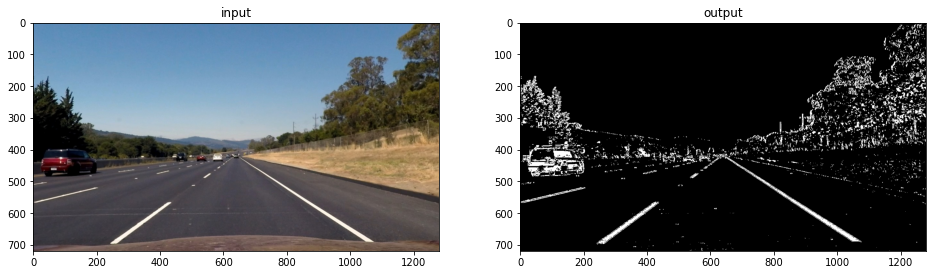

In [31]:
# Compare input and output images

_id = 0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title('input')
ax1.imshow(cv2.cvtColor(_input_imgs_3[_id],cv2.COLOR_BGR2RGB))
ax2.set_title('output')
ax2.imshow(_output_imgs_3[_id], cmap='gray')
plt.savefig(fname="output_images/binary_output_{}.png".format(_id))

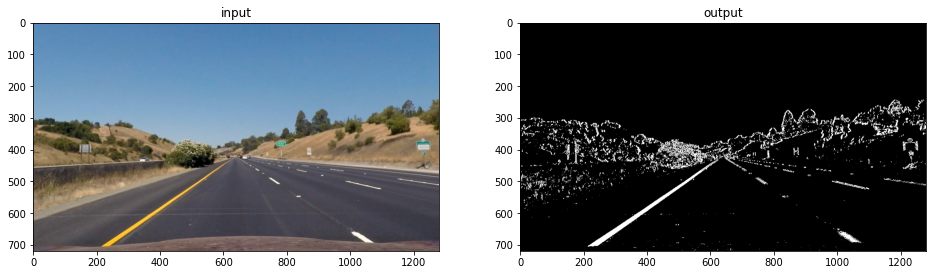

In [32]:
# Compare input and output images

_id = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title('input')
ax1.imshow(cv2.cvtColor(_input_imgs_3[_id],cv2.COLOR_BGR2RGB))
ax2.set_title('output')
ax2.imshow(_output_imgs_3[_id], cmap='gray')
plt.savefig(fname="output_images/binary_output_{}.png".format(_id))

## 3. Apply a perspective transform.

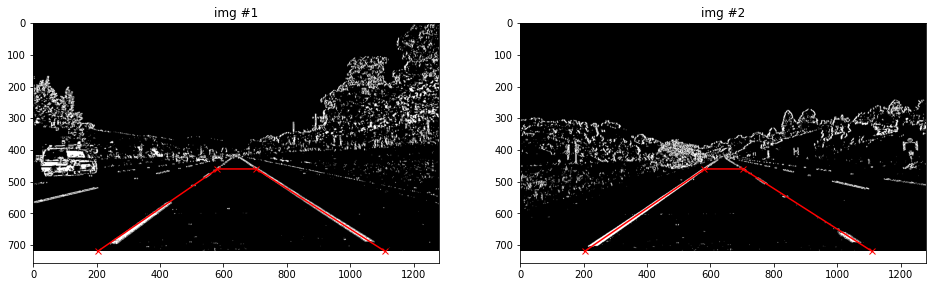

In [33]:
"""
finding good parameters for perspective transform.
Note that I choose parameters using straight lane lines.
"""

src_t = np.asarray([[203, 581, 703, 1110], [720, 460, 460, 720]])
dst_t = np.asarray([[320, 320, 960, 960], [720, 0, 0, 720]])

# visualize src and dst points for straight_lines
_id = 0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title('img #1')
ax1.plot(src_t[0], src_t[1], 'r-x')
ax1.imshow(_output_imgs_3[_id], cmap='gray')

_id = 1
ax2.set_title('img #2')
ax2.plot(src_t[0], src_t[1], 'r-x')
ax2.imshow(_output_imgs_3[_id], cmap='gray')

In [34]:
def calculate_prespective_transform_matrix(src_t, dst_t):
    src = src_t.T.astype(np.float32)
    dst = dst_t.T.astype(np.float32)
    return cv2.getPerspectiveTransform(src, dst)

In [35]:
def calculate_perspective_transform_matrices():
    src_t = np.asarray([[203, 581, 703, 1110], [720, 460, 460, 720]])
    dst_t = np.asarray([[320, 320, 960, 960], [720, 0, 0, 720]])
    M = calculate_prespective_transform_matrix(src_t, dst_t)
    Minv = calculate_prespective_transform_matrix(dst_t, src_t)
    return M, Minv

In [36]:
def apply_perspective_transform(img, M):
    shape = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, shape, flags=cv2.INTER_LINEAR)

### 3.1 Provide an example of a transformed image.

In [37]:
_input_imgs_4 = _output_imgs_3
_output_imgs_4 = []

_M, _Minv = calculate_perspective_transform_matrices()

for _input_img_4 in _input_imgs_4:
    _output_img_4 = apply_perspective_transform(_input_img_4, _M)
    _output_imgs_4.append(_output_img_4)

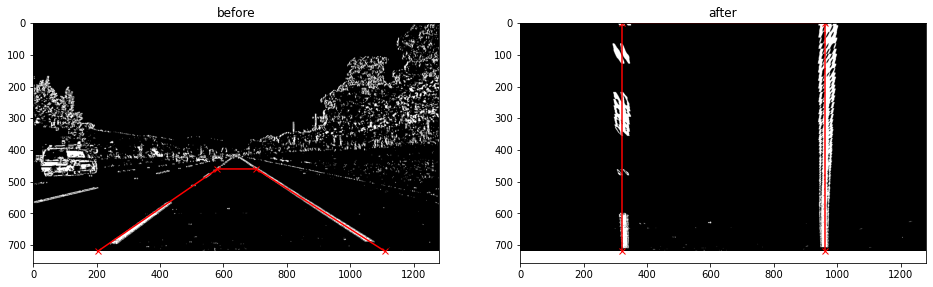

In [38]:
_id = 0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title('before')
ax1.plot(src_t[0], src_t[1], 'r-x')
ax1.imshow(_input_imgs_4[_id], cmap='gray')
ax2.set_title('after')
ax2.plot(dst_t[0], dst_t[1], 'r-x')
ax2.imshow(_output_imgs_4[_id], cmap='gray')
plt.savefig(fname="output_images/ptransform_output_{}.png".format(_id))

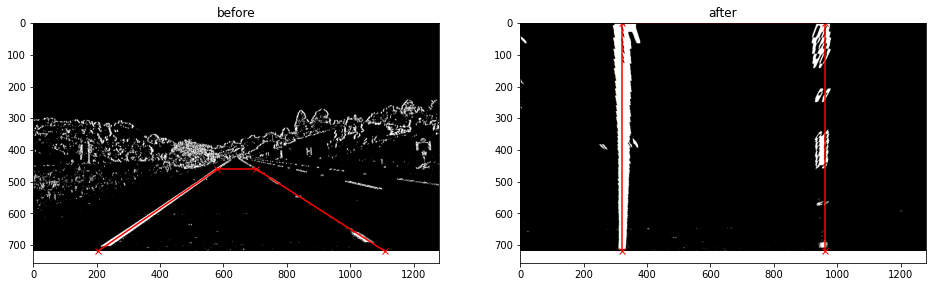

In [39]:
_id = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title('before')
ax1.plot(src_t[0], src_t[1], 'r-x')
ax1.imshow(_input_imgs_4[_id], cmap='gray')
ax2.set_title('after')
ax2.plot(dst_t[0], dst_t[1], 'r-x')
ax2.imshow(_output_imgs_4[_id], cmap='gray')
plt.savefig(fname="output_images/ptransform_output_{}.png".format(_id))

## 4. Detect lane pixels and fit to find the lane boundary.

In [40]:
def fit_polynomial(leftx, lefty, rightx, righty, xm_per_pix=1, ym_per_pix=1):
    leftx = leftx * xm_per_pix
    lefty = lefty * ym_per_pix
    rightx = rightx * xm_per_pix
    righty = righty * ym_per_pix
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

In [41]:
def find_lane_pixels_for_demo(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

### 4.1. provide an example of detected lane boundaries.

In [42]:
# This function is used only to draw lane line boundaries
def plot_lane_boundaries(binary_warped, ax):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_for_demo(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    ax.imshow(out_img)

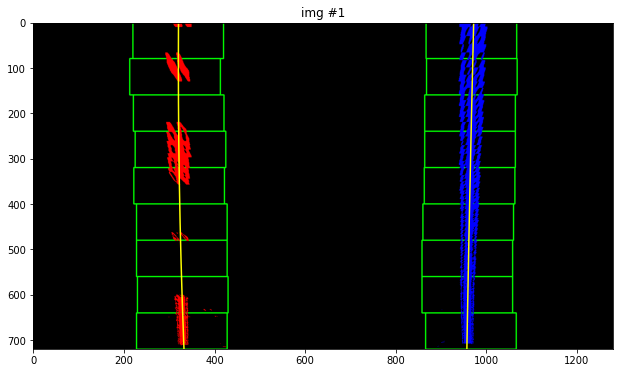

In [43]:
_input_imgs_5 = _output_imgs_4

# visualize src and dst points for straight_lines
_id = 0
f, ax1 = plt.subplots(1, 1, figsize=(16,6))
ax1.set_title('img #1')
plot_lane_boundaries(_input_imgs_5[_id], ax1)
plt.savefig(fname="output_images/lane_output_{}.png".format(_id))

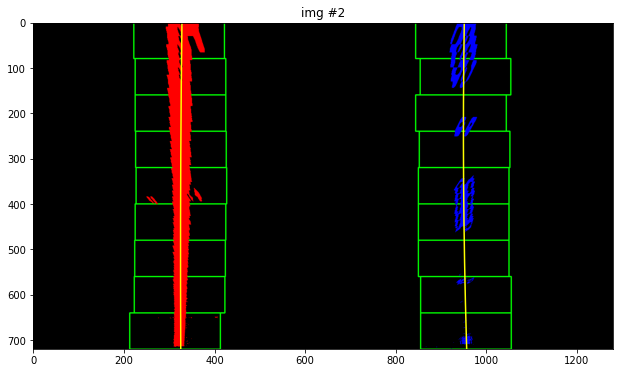

In [44]:
_input_imgs_5 = _output_imgs_4

_id = 1
f, ax1 = plt.subplots(1, 1, figsize=(16,6))
ax1.set_title('img #2')
plot_lane_boundaries(_input_imgs_5[_id], ax1)
plt.savefig(fname="output_images/lane_output_{}.png".format(_id))

### 4.2 Fast version

In [45]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [46]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = (
        (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))
    )
    right_lane_inds = (
        (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
        (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin))
    )
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

## 5. Determine the curvature of the lane and vehicle position with respect to center.

In [47]:
def measure_curvature_and_position_in_meters(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    return measure_curvature_and_position(binary_warped, xm_per_pix, ym_per_pix)

def measure_curvature_and_position(binary_warped, xm_per_pix=1, ym_per_pix=1):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    
    left_fit, right_fit = fit_polynomial(
        leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = (binary_warped.shape[0]-1) * ym_per_pix
    
    # Measure curvature
    curvature = measure_curvature(left_fit, right_fit, y_eval)
    
    # Measure the position of a car
    x_center = binary_warped.shape[1]/2 * xm_per_pix
    position = measure_position(left_fit, right_fit, y_eval, x_center)

    return int(round(curvature)), round(position, 2)
    
def measure_curvature(left_fit, right_fit, y_eval):
    left_curverad = calculate_r(left_fit[0], left_fit[1], y_eval)
    right_curverad = calculate_r(right_fit[0], right_fit[1], y_eval)
    return min(left_curverad, right_curverad)

def measure_position(left_fit, right_fit, y_eval, x_center):
    """
    Return the position of a car.
    """
    left = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    center_to_left = x_center - left
    center_to_right = right - x_center
    return center_to_left - center_to_right

def calculate_r(a, b, y):
    numer = (1 +(2*a*y + b)**2)**(3/2)
    denom = np.abs(2*a)
    return numer/denom

### 5.1 sample output

In [48]:
_id = 0
(curvature, position) = measure_curvature_and_position(_output_imgs_4[_id])
print("Curvature in pixels: {}, Position pixels: {}".format(curvature, position))
(curvature, position) = measure_curvature_and_position_in_meters(_output_imgs_4[_id])
print("Curvature in meters: {}, Position meters: {}".format(curvature, position))

Curvature in pixels: 15979, Position pixels: -9.75
Curvature in meters: 5236, Position meters: -0.05


In [49]:
_id = 1
(curvature, position) = measure_curvature_and_position(_output_imgs_4[_id])
print("Curvature in pixels: {}, Position pixels: {}".format(curvature, position))
(curvature, position) = measure_curvature_and_position_in_meters(_output_imgs_4[_id])
print("Curvature in meters: {}, Position meters: {}".format(curvature, position))

Curvature in pixels: 15853, Position pixels: -2.16
Curvature in meters: 5200, Position meters: -0.01


### 6. Warp the detected lane boundaries back onto the original image.

In [50]:
def generate_curve_points(leftx, lefty, rightx, righty, ymax=720):
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    
    ploty = np.linspace(0, ymax-1, 200)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_points = np.vstack([left_fitx, ploty]).transpose()
    right_points = np.vstack([right_fitx, ploty]).transpose()
    return left_points, right_points, left_fit, right_fit

In [51]:
def overlay_detected_lane(undistorted, left, right, Minv):
    overlay_img = np.zeros_like(undistorted)

    # create lane points
    lane_pts = np.vstack([left.squeeze(), np.flipud(right.squeeze())])
    
    # apply perspective transform to lane points
    transformed_lane_pts = cv2.perspectiveTransform(np.array([lane_pts]), Minv)
    
    # remove points which has y larger than 720
    transformed_lane_pts = transformed_lane_pts[:, transformed_lane_pts[0,:,1] <= 720, :]
    
    # draw a polygon for lane
    cv2.fillPoly(overlay_img, np.int_([transformed_lane_pts]), (0, 255, 0))

    # overlay a lane polygon onto undistorted image
    result = cv2.addWeighted(undistorted, 1, overlay_img, 0.3, 0)

    return result

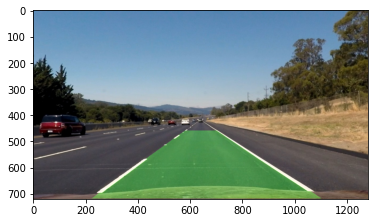

In [52]:
_input_imgs_7_1 = _output_imgs_2 # undistorted_image
_input_imgs_7_2 = _output_imgs_4 # warped_image

_M, _Minv = calculate_perspective_transform_matrices()

_id = 0
_leftx, _lefty, _rightx, _righty = find_lane_pixels(_input_imgs_7_2[_id])
_left, _right, _, _ = generate_curve_points(_leftx, _lefty, _rightx, _righty)
_output_img = overlay_detected_lane(_input_imgs_7_1[_id], _left, _right, _Minv)
plt.imshow(cv2.cvtColor(_output_img, cv2.COLOR_BGR2RGB))
plt.savefig(fname="output_images/overlay_output_{}.".format(_id))

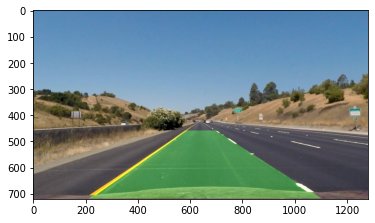

In [53]:
_input_imgs_7_1 = _output_imgs_2 # undistorted_image
_input_imgs_7_2 = _output_imgs_4 # warped_image

_M, _Minv = calculate_perspective_transform_matrices()

_id = 1
_leftx, _lefty, _rightx, _righty = find_lane_pixels(_input_imgs_7_2[_id])
_left, _right, _, _ = generate_curve_points(_leftx, _lefty, _rightx, _righty)
_output_img = overlay_detected_lane(_input_imgs_7_1[_id], _left, _right, _Minv)
plt.imshow(cv2.cvtColor(_output_img, cv2.COLOR_BGR2RGB))
plt.savefig(fname="output_images/overlay_output_{}.".format(_id))

## 7. Create an end-to-end lane detection pipeline

In [54]:
def func(img, camera_matrix, dist_coeffs, ptransform_matrix, inv_ptransform_matrix): 
    """
    This is the first pipeline that work for the provided examples.
    """
    
    global left_fit
    global right_fit
    
    img_copy = img.copy()
    img_undistort = apply_undistortion(img_copy, camera_matrix, dist_coeffs)
    img_binary = apply_binary_transformation_with_thresholds(img_undistort)
    img_warped = apply_perspective_transform(img_binary, ptransform_matrix)

    if left_fit is None:
        leftx, lefty, rightx, righty = find_lane_pixels(img_warped)
    else:
        leftx, lefty, rightx, righty = search_around_poly(img_warped, left_fit, right_fit)
        
    left, right, left_fit, right_fit = generate_curve_points(leftx, lefty, rightx, righty, img.shape[0])
    img_output = overlay_detected_lane(img_undistort, left, right, inv_ptransform_matrix)

    curvature, position = measure_curvature_and_position_in_meters(img_warped)

    texts = ['Radius of Curvature: {0:5d}m'.format(curvature),
             'Vehicle is {:02.2f}m left of the center'.format(position)]
    for i, text in enumerate(texts):
        cv2.putText(img=img_output,
                    text=text,
                    org=(30, (i+1)*80),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1.6,
                    color=(255, 255, 255),
                    thickness=2)
    
    return img_output

### 8.1 Test an end-to-end lane detection pipeline

In [55]:
_camera_matrix, _dist_coeffs = compute_camera_calibration()
_ptransform_matrix, _inv_ptransform_matrix = calculate_perspective_transform_matrices()

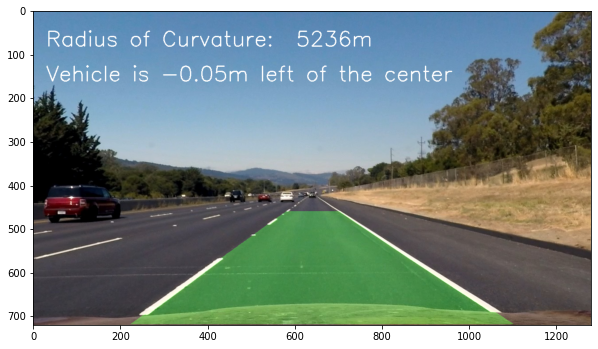

<Figure size 432x288 with 0 Axes>

In [56]:
_id = 0
_path = glob.glob('test_images/straight_lines*.jpg')[_id]

left_fit = None
right_fit = None

_img = cv2.imread(_path)
_img_output = func(_img,
                   _camera_matrix,
                   _dist_coeffs,
                   _ptransform_matrix,
                   _inv_ptransform_matrix)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(_img_output, cv2.COLOR_BGR2RGB))
plt.show()
plt.savefig(fname="output_images/final_output_{}.png".format(_id))

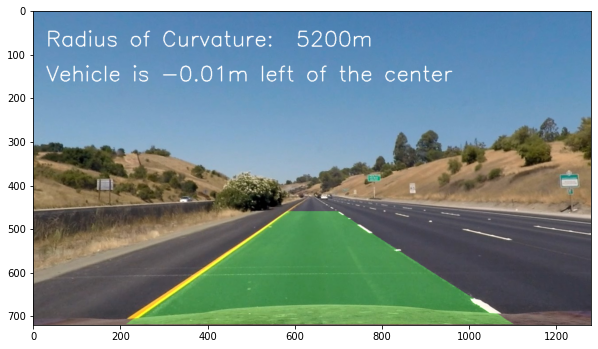

<Figure size 432x288 with 0 Axes>

In [57]:
_id = 1
_path = glob.glob('test_images/straight_lines*.jpg')[_id]

left_fit = None
right_fit = None

_img = cv2.imread(_path)
_img_output = func(_img,
                   _camera_matrix,
                   _dist_coeffs,
                   _ptransform_matrix,
                   _inv_ptransform_matrix)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(_img_output, cv2.COLOR_BGR2RGB))
plt.show()
plt.savefig(fname="output_images/final_output_{}.png".format(_id))

### 9. Apply the lane detection algorithm to video

In [60]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [61]:
# Global variables
camera_matrix, dist_coeffs = compute_camera_calibration()
ptransform_matrix, inv_ptransform_matrix = calculate_perspective_transform_matrices()
left_fit, right_fit = None, None

In [62]:
def process_image(img):
    global camera_matrix
    global dist_coeffs
    global ptransform_matrix
    global inv_ptransform_matrix
    return func(img,
                camera_matrix,
                dist_coeffs,
                ptransform_matrix,
                inv_ptransform_matrix, )

In [64]:
white_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 3/1260 [00:00<01:01, 20.40it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 11min 52s, sys: 21.9 s, total: 12min 14s
Wall time: 1min 34s


In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))